# Xgboost

### 주요 장점
- 뛰어난 예측 성능
- GBM 대비 빠른 수행시간
    - CPU 병렬 처리, GPU 지원
- 다양한 성능 향상 기능
    - 규제(Regularization) 기능 탑재
    - Tree Pruning
- 다양한 편의 기능
    - 조기 중단(Early Stopping)
    - 자체 내장된 교차 검증
    - 결손값 자체 처리

### XGBoost 파이썬 구현(Scikit-Learn)
- 사이킷런 프레임과 통합될 수 있는 파이썬 Wrapper Class 지원
    - XGBClassifier
    - XGBRegressor
- 학습과 예측을 다른 사이킷런 API와 동일하게 fit()과 predict()로 수행.
- GridSearchCV와 같은 다른 사이킷런 모듈과 같이 사용 가능

### XGBoost 파이썬 래퍼와 사이킷런 래퍼 API 비교
- **파이썬 Wrapper**
    - 사용 모듈 : from xgboost as xgb
    - 학습용과 테스트용 
        - DMatrix 객체를 별도 생성
        - train = xgb.DMatrix(data = X_train, label = y_train)
        - DMatrix 생성자로 피처 데이터 세트와 레이블 데이터 세트를 입력
    - 학습 API
        - Xgb_model = xgb.train()
        - Xgb_model은 학습된 객체를 반환 받음
    - 예측 API
        - xgb.train()으로 학습된 객체에서 predict() 호출. 즉 Xgb_model.predict()
        - 이때 반환 결과는 예측 결과가 아니라 예측 결과를 추정하는 **확률값** 반환
    - 피처 중요도 시각화
        - plot_importance()



- **사이킷런 Wrapper**
    - 사용 모듈 : from xgboost import XGBClassifier
    - 학습용과 테스트용
        - 넘파이나 판다스를 이용
    - 학습 API
        - XGBClassifier.fit()
    - 예측 API
        - XGBClassifier.predict()
        - 예측 결과값 반환
    - 피처 중요도 시각화
        -plot_importance()

### XGBoost 파이썬 래퍼와 사이킷런 래퍼 하이퍼 파라미터 비교
- 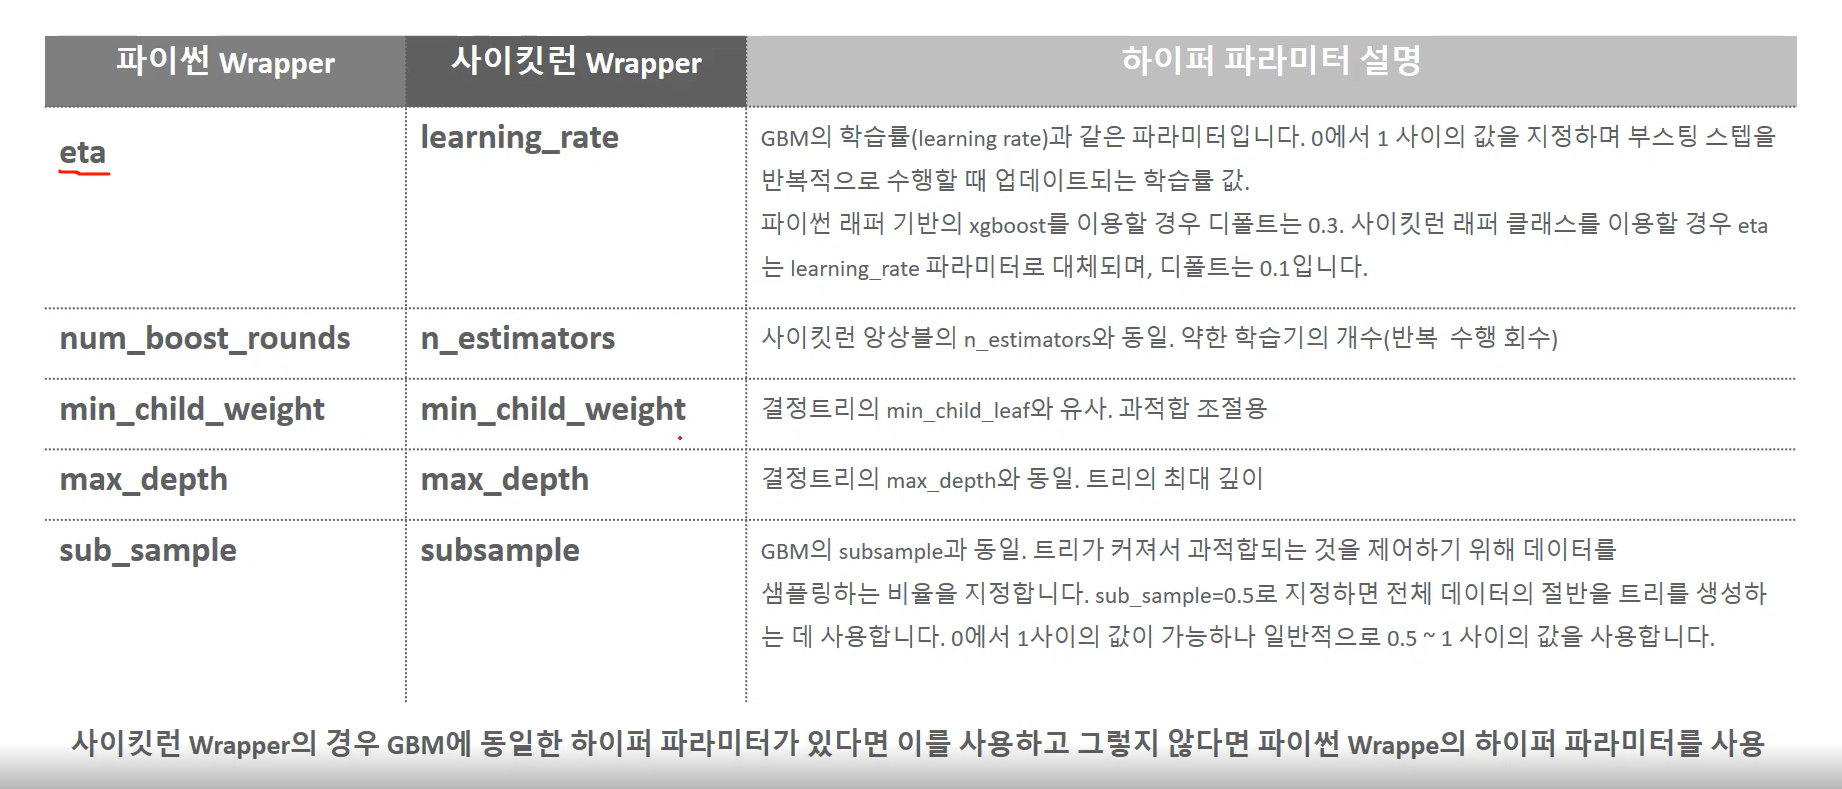
- 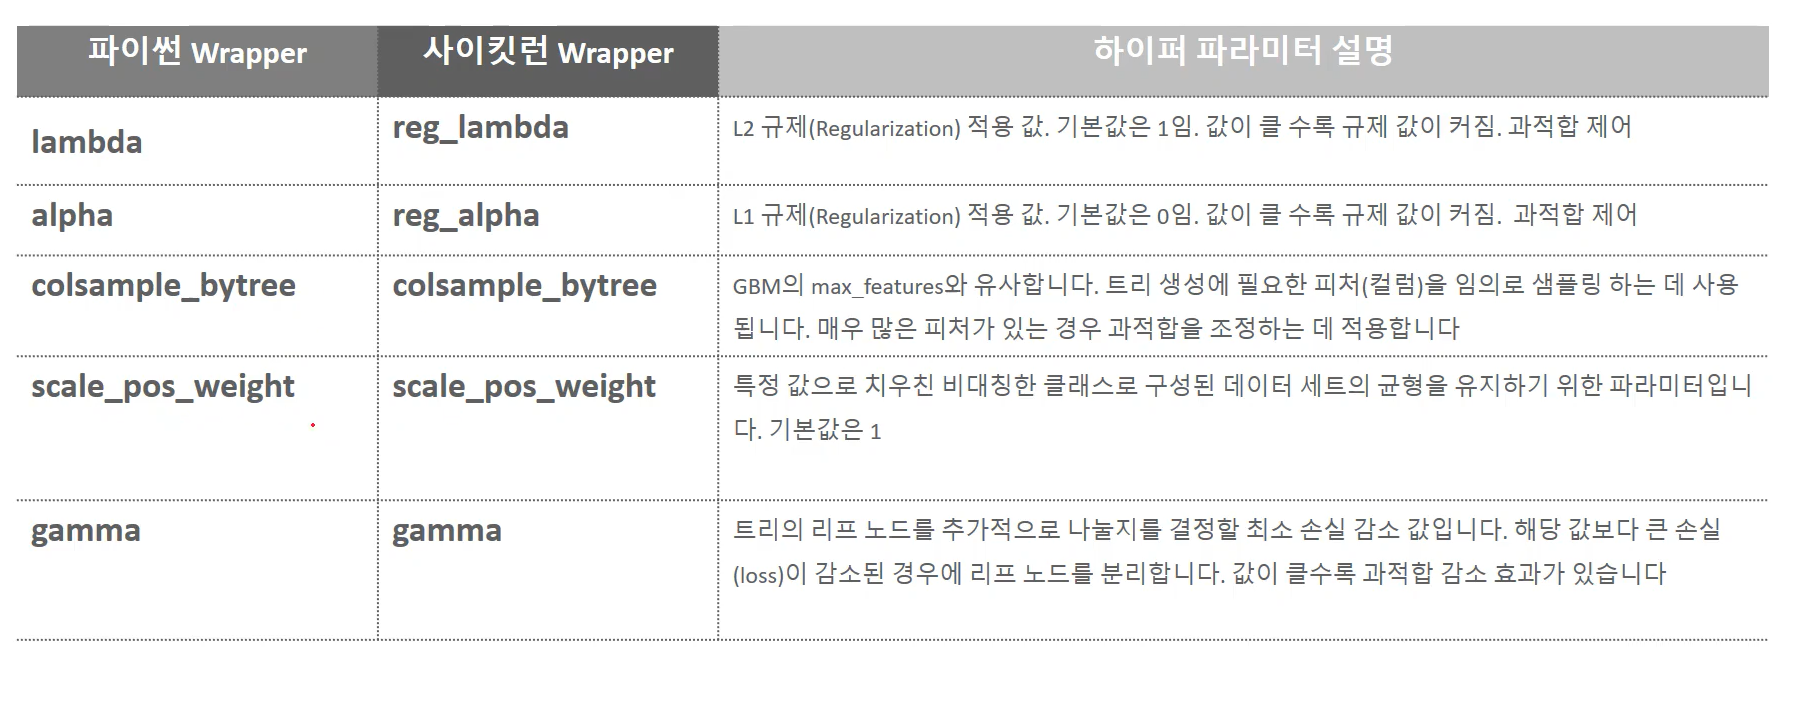

### XGBoost 조기 중단 기능(Early Stopping)
- Xgboost는 특정 반복 횟수만큼 더 이상 비용함수가 감소하지 않으면 지정된 반복횟수를 다 완료하지 않고 수행을 종료할 수 있음
- 학습을 위한 시간을 단축 시킬 수 있음. 특히 최적화 튜닝 단계에서 적절하게 사용 가능.
- 너무 반복 횟수를 단축할 경우 예측 성능 최적화가 안된 상태에서 학습이 종료될 수 있으므로 유의 필요
- 조기 중단 설정을 위한 주요 파라미터
    - early_stopping_rounds : 더 이상 비용 평가 지표가 감소하지 않는 최대 반복횟수.
    - eval_metric : 반복 수행 시 사용하는 비용 평가 지표.
    - eval_set : 평가를 수행하는 별도의 검증 데이터 세트. 일반적으로 검증 데이터 세트에서 반복적으로 비용 감소 성능 평가.

### (실습) 파이썬 Native XGBoost 적용 - 위스콘신 Breast Cancer 데이터 셋

**데이터 세트 로딩하기**

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# xgboost 패키지 로딩하기
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df["target"] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [8]:
print(dataset.target_names)
print(cancer_df["target"].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [10]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 컬럼이 Label이므로 Feature용 DataFrame은 cancer_df의 첫번째 컬럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


**학습과 예측 데이터 세트를 DMatrix로 변환**
- DMatrix는 넘파이 array, DataFrame에서도 변환 가능

In [11]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습 ,검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

**하이퍼 파라미터 설정**

In [12]:
params = {
    "max_depth" : 3, 
    "eta" : 0.05,
    "objective" : "binary:logistic",
    "eval_metric" : "logloss"
}
num_rounds = 400

**주어진 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달하고 학습**

In [13]:
# 학습 데이터셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다.
eval_list = [(dtr, "train"), (dval, "eval")]  # eval_list = [(dval, "eval")]만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds,\
    early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

**predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**

In [18]:
pred_probs = xgb_model.predict(dtest)
print("predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨")
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
pred = [1 if x>0.5 else 0 for x in pred_probs]
print("예측값 10개만 표시 : ", pred[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [19]:
# Native Xgboost의 경우 predict를 하면 예측 확률이 도출된다.
pred_probs

array([0.8447872 , 0.00842587, 0.6796298 , 0.08113331, 0.9751338 ,
       0.9988939 , 0.9983084 , 0.9980654 , 0.99637896, 0.00138468,
       0.00252283, 0.00154995, 0.99780875, 0.99829525, 0.99691856,
       0.9965521 , 0.99120796, 0.9982718 , 0.9970682 , 0.9978916 ,
       0.00202923, 0.10774372, 0.00137198, 0.9989255 , 0.00107862,
       0.7800014 , 0.00295459, 0.00154995, 0.9966723 , 0.05379276,
       0.958738  , 0.00149019, 0.9700533 , 0.8656249 , 0.00678389,
       0.00140975, 0.97810876, 0.99713576, 0.24059245, 0.9972307 ,
       0.35760084, 0.99708337, 0.9919429 , 0.99659145, 0.9962838 ,
       0.9179466 , 0.036952  , 0.997417  , 0.99325067, 0.99804085,
       0.99648905, 0.00236221, 0.9979361 , 0.99784875, 0.9960328 ,
       0.99391055, 0.9984106 , 0.99635327, 0.9967404 , 0.896291  ,
       0.9967794 , 0.9520696 , 0.00349248, 0.00202715, 0.9980167 ,
       0.98225844, 0.00349248, 0.99056447, 0.9972249 , 0.9978916 ,
       0.00297725, 0.99731344, 0.00163038, 0.98887384, 0.99624

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
get_clf_eval(y_test, pred, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


**Feature Importance 시각화**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

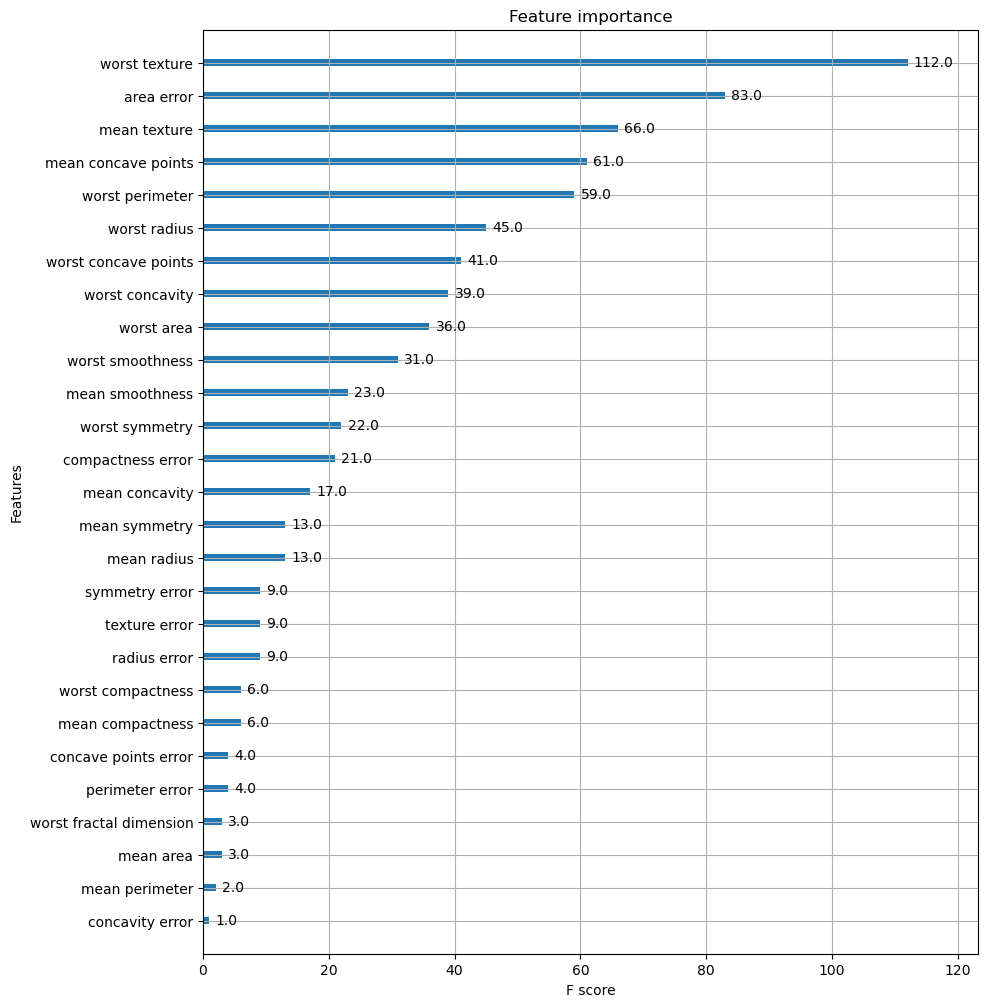

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model, ax = ax)

### 사이킷런 Wrapper XGBoost 개요 및 적용

**사이킷런 래퍼 클래스 임포트, 학습 및 예측**

In [28]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 입력 안해도 상관 없음
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [29]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


**early stopping을 50으로 설정하고 재학습/예측/평가**

In [34]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3)
evals = [(X_tr, y_tr), (X_val, y_val)]

# early stopping을 위해서는 valid dataset이 필요함
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = "logloss",\
    eval_set = evals, verbose = True)
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[28]	validation_0-logloss:0.16481	validation_1-logloss:0.32099
[29]	validation_0-logloss:0.15835	validation_1-logloss:0.31671
[30]	validation_0-logloss:0.15225	validation_1-logloss:0.31277
[31]	validation_0-logloss:0.14650	validation_1-logloss:0.30882
[32]	validation_0-logloss:0.14102	validation_1-logloss:0.30437
[33]	validation_0-logloss:0.13590	validation_1-logloss:0.30103
[34]	validation_0-logloss:0.13109	validation_1-logloss:0.29794
[35]	validation_0-logloss:0.12647	validation_1-logloss:0.29499
[36]	validation_0-logloss:0.12197	validation_1-logloss:0.29295
[37]	validation_0-logloss:0.11784	validation_1-logloss:0.29043
[38]	validation_0-logloss:0.11379	validation_1-logloss:0.28927
[39]	validation_0-logloss:0.10994	validation_1-logloss:0.28578
[40]	validation_0-logloss:0.10638	validation_1-logloss:0.28364
[41]	validation_0-logloss:0.10302	validation_1-logloss:0.28183
[42]	validation_0-logloss:0.09963	validation_1-logloss:0.28005
[43]	validation_0-logloss:0.09649	validation_1-logloss:

In [35]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


**plot_importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

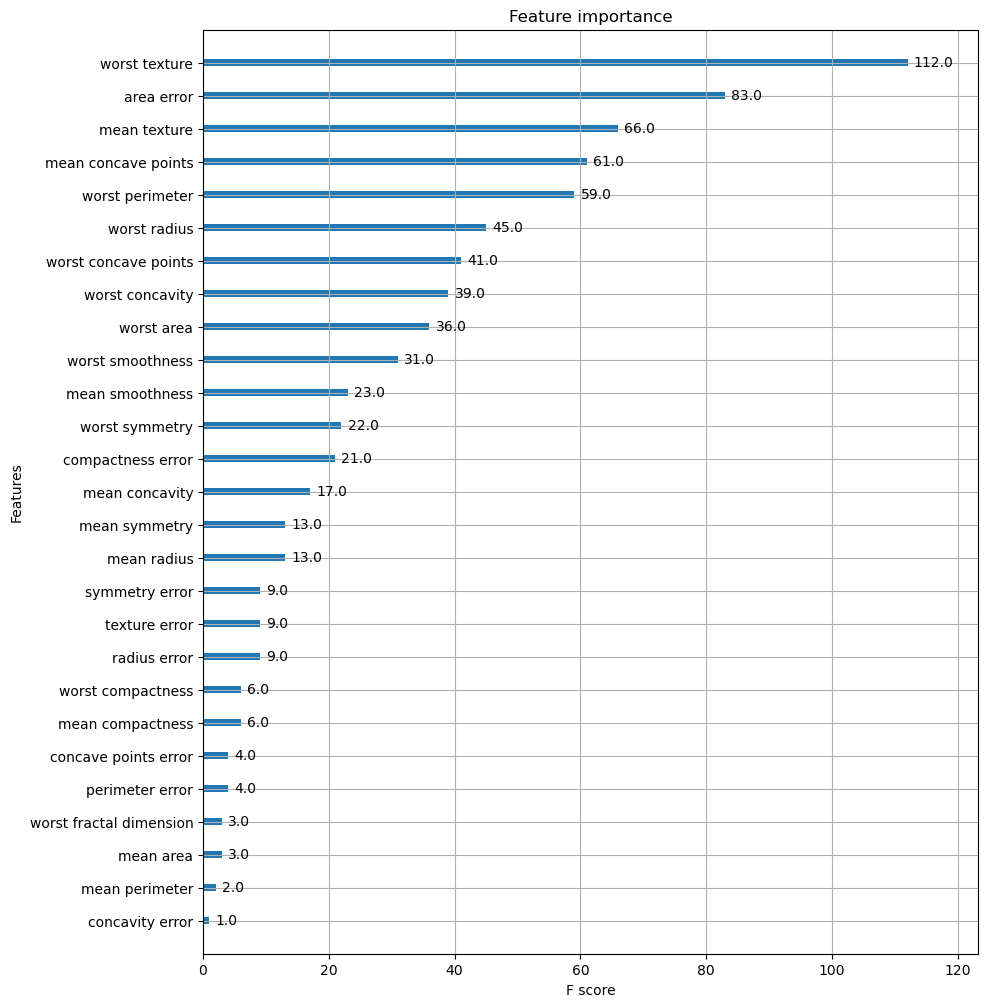

In [39]:
fig, ax = plt.subplots(figsize = (10,12))
#  사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax = ax)